In [ ]:

# Check if CUDA (GPU) is available
import torch
print (torch.cuda.is_available())
# Get the number of available CUDA devices
print(torch.cuda.device_count())
# Get the index of the current CUDA device
print (torch.cuda.current_device())
print (torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Check which device we got

cuda:0


Resolving data files:   0%|          | 0/18537 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2058 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2468 [00:00<?, ?it/s]

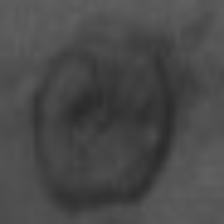

In [ ]:
# Define the paths for train, validation, and test folders
from datasets import load_dataset
organoid_train='D:\HDD Giovanni\Desktop\Final_Organoids_Dataset-20230921T090135Z-001\Final_Organoids_Dataset\\train_folder'
organoid_val='D:\HDD Giovanni\Desktop\Final_Organoids_Dataset-20230921T090135Z-001\Final_Organoids_Dataset\\val_folder'
organoid_test='D:\HDD Giovanni\Desktop\Final_Organoids_Dataset-20230921T090135Z-001\Final_Organoids_Dataset\\test_folder'

# Load datasets for train, validation, and test from image folders
db_dir=organoid_train
db_dir2=organoid_val
db_dir3=organoid_test

# Load datasets without saving additional information and without verification checks
dataset = load_dataset("imagefolder", data_dir=db_dir, save_infos=False, verification_mode='no_checks')
dataset2 = load_dataset("imagefolder", data_dir=db_dir2, save_infos=False, verification_mode='no_checks')
dataset3 = load_dataset("imagefolder", data_dir=db_dir3, save_infos=False, verification_mode='no_checks')

# Access the first image in the training dataset
dataset["train"][0]["image"]

In [ ]:
# Define the model checkpoint for Vision Transformer (ViT) model
model_checkpoint = "google/vit-base-patch16-224"
print ('ok')

ok


In [ ]:
# Define the Hugging Face API key (XXXX for privacy)
hf_key='hf_EMyHPMUqzXXXXXXXXXXXqfilqlrVJewBAUwe'

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Install and use the wandb library and login

!pip install wandb
import wandb
wandb.login()


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


wandb: Currently logged in as: gcicceri. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Set the environment variable WANDB_PROJECT to 'organoids'
%env WANDB_PROJECT=organoids

env: WANDB_PROJECT=organoids


In [ ]:
# Import and Load the accuracy metric from the datasets library

from datasets import load_metric
metric = load_metric("accuracy")

dataset # 'dataset' contains a loaded dataset

# Access an example from the training split of the dataset
example = dataset["train"][10]
example

C:\Users\Giovanni Cicceri\AppData\Local\Temp\ipykernel_28864\2879941938.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label': 0}

In [ ]:
# Access the features information of the training split in the dataset
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['0', '1', '2', '3'], id=None)}

In [ ]:
# Access the label feature information of the training split in the dataset
dataset["train"].features["label"]

ClassLabel(names=['0', '1', '2', '3'], id=None)

In [ ]:
# Extract label names from the training splits of all three datasets and create mappings between labels and indices
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

labels2 = dataset2["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels2):
    label2id[label] = i
    id2label[i] = label

labels3 = dataset3["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels3):
    label2id[label] = i
    id2label[i] = label

# Access the label corresponding to index 0
id2label[0]

'0'

In [ ]:
# Import and Load the image processor from the specified pre-trained model checkpoint
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
# Display the image processor object
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
import random
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter

class RandAugment:
    def __init__(self, num_ops=2):
        self.num_ops = num_ops
        # Define a list of torchvision augmentations to apply randomly
        self.augmentations = [
            RandomHorizontalFlip(),
            RandomRotation(30),
            ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
        ]

    def __call__(self, img):
        # Apply a random subset of augmentations from the list to the input image
        ops = random.sample(self.augmentations, self.num_ops)
        for op in ops:
            img = op(img)
        return img

In [ ]:
# Import commonly used image transformations from the torchvision library
from torchvision.transforms import RandomResizedCrop, Resize, Compose, CenterCrop, Normalize, ToTensor RandAugment

# Normalize the images using the statistics from the image processor
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

# Determine the size for image transformations
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

# Define the transformations for training and validation data
train_transforms = Compose([RandomResizedCrop(size), CenterCrop(size), RandAugment(), ToTensor(), normalize])
val_transforms = Compose([Resize(size), CenterCrop(size), ToTensor(), normalize])

# Define preprocess functions for training and validation datasets
def preprocess_train(examples):
    examples["pixel_values"] = [train_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

def preprocess_val(examples):
    examples["pixel_values"] = [val_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [ ]:
# Import the transforms module from the torchvision library
from torchvision import transforms

# Print a message to indicate successful import
print ('ok')

ok


In [ ]:
# Get training, validation, and test datasets
train_ds = dataset['train']
val_ds = dataset2['train']
test_ds = dataset3['train']

# Cast image column to undecoded Image type for all datasets
from datasets import Image
train_ds_undec = train_ds.cast_column('image', Image(decode=False))
val_ds_undec = val_ds.cast_column('image', Image(decode=False))
test_ds_undec = test_ds.cast_column('image', Image(decode=False))

# Set preprocess transformations for training, validation, and test datasets
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_val)

In [ ]:
#example at index 1856
train_ds[1856]

{'label': 0,
 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]])}

In [ ]:
# Import torch and check its version
import torch
print(torch.__version__)

# Import modules for distributed training from the torch library
from torch.distributed.algorithms.join import Join
import torch.distributed.algorithms.join
# Import distributed utilities from the torch library
import torch.distributed as dist

# Import classes for Vision Transformer from the transformers library
from transformers import ViTImageProcessor, ViTModel

# Import Image module from PIL library and requests module for image retrieval
from PIL import Image
import requests

# Print a message to indicate successful imports
print ('ok')

In [ ]:
# Import necessary classes from the transformers library
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

# Load the pre-trained image classification model from the specified checkpoint
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    ignore_mismatched_sizes=True,  # Ignore size mismatches between model and loaded labels
    num_labels=len(labels),         # Set the number of output labels
    id2label=id2label,              # Mapping from label indices to label names
    label2id=label2id               # Mapping from label names to label indices
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
# Define a collate function for batch processing of examples
def collate_fn(examples):
    # Stack pixel values of examples into a tensor
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # Convert labels of examples into a tensor
    labels = torch.tensor([example["label"] for example in examples])
    # Return a dictionary containing pixel values and labels
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# Import necessary libraries for computing evaluation metrics, visualizing confusion matrices, and plotting graphs using Matplotlib.
import numpy as np
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Define class names for confusion matrix display
class_names = labels

def compute_metrics(eval_pred):
  # Extract labels and predictions from the evaluation prediction
  labels = eval_pred.label_ids
  predictions = np.argmax(eval_pred.predictions, axis=1)
  # Compute accuracy
  acc = accuracy_score(labels, predictions)
  # Plot confusion matrix
  ConfusionMatrixDisplay.from_predictions(labels, predictions, cmap='viridis', colorbar=False, display_labels=class_names)
  plt.show()

  # Return accuracy
  return {
      'accuracy': acc, }
  return metrics.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
# Import the TrainingArguments class and the Trainer class from the transformers library.
from transformers import TrainingArguments
from transformers import Trainer

In [ ]:
# Set the batch size for training and evaluation
batch_size = 128

In [ ]:
args = TrainingArguments(
    output_dir='D:\HDD Giovanni\Desktop\organoids',  # Directory to save trained models and logs
    f"-prova_organoid",                              # Additional identifier for the output directory
    remove_unused_columns=False,                     # Whether to remove unused columns from datasets
    evaluation_strategy="epoch",                     # Evaluation strategy during training
    save_strategy="epoch",                           # Model saving strategy during training
    save_total_limit=2,                              # Total number of checkpoints to save
    learning_rate=1.0e-5,                            # Learning rate for training
    optim="adamw_torch",                             # Optimizer used for training
    per_device_train_batch_size=batch_size,          # Batch size per GPU during training
    gradient_accumulation_steps=4,                   # Number of gradient accumulation steps
    per_device_eval_batch_size=batch_size,           # Batch size per GPU during evaluation
    num_train_epochs=40,                             # Total number of training epochs
    warmup_ratio=0.1,                                # Ratio of warmup steps to total training steps
    logging_steps=1,                                 # Logging interval during training
    load_best_model_at_end=True,                     # Whether to load the best model at the end of training
    greater_is_better=True,                          # Whether higher metric values are better
    report_to=['wandb'],                             # Reporting platform for training metrics
    push_to_hub=True,                                # Whether to push trained model to the Hub
    metric_for_best_model="accuracy"                 # Metric used to determine the best model
)

# Initialize the Trainer object for model training
trainer = Trainer(
    model=model,                                    # Pretrained model to be fine-tuned
    args=args,                                      # Training arguments
    data_collator=collate_fn,                       # Data collator for batch processing
    train_dataset=train_ds,                         # Training dataset
    eval_dataset=val_ds,                            # Evaluation dataset
    tokenizer=image_processor,                      # Tokenizer for preprocessing images
    compute_metrics=compute_metrics                 # Function to compute evaluation metrics
)


D:\HDD Giovanni\Desktop\organoids-prova_organoid is already a clone of https://huggingface.co/gcicceri/organoids-prova_organoid. Make sure you pull the latest changes with `repo.git_pull()`.


Epoch,Training Loss,Validation Loss


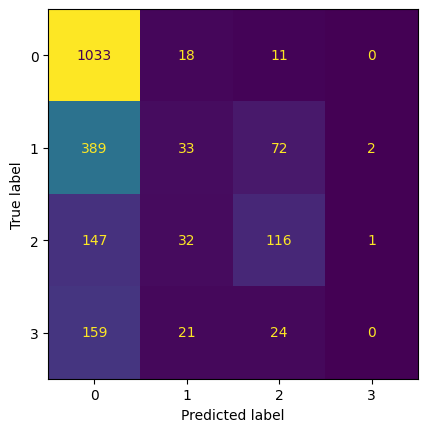

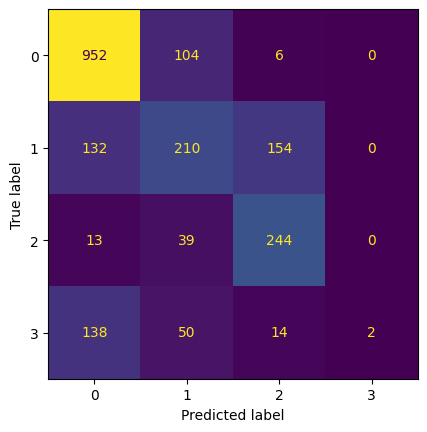

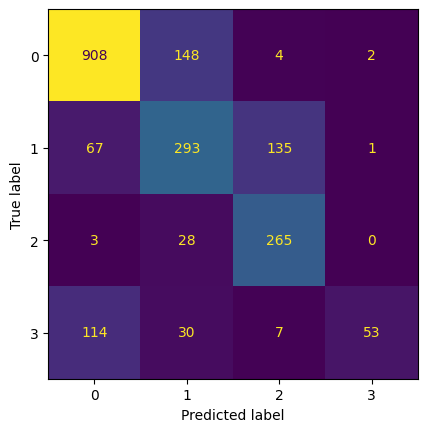

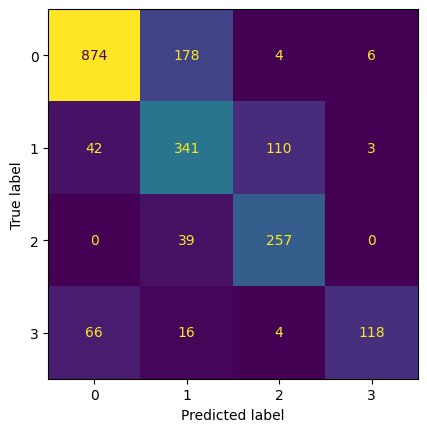

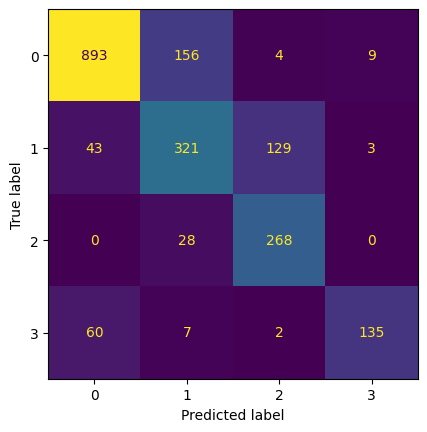

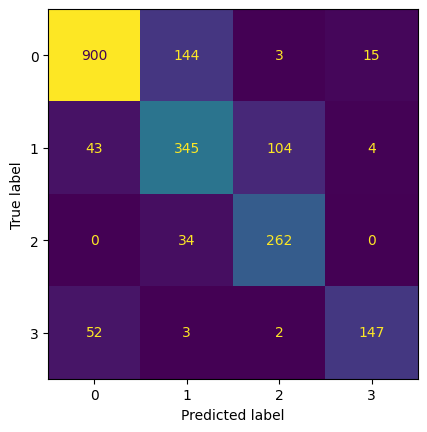

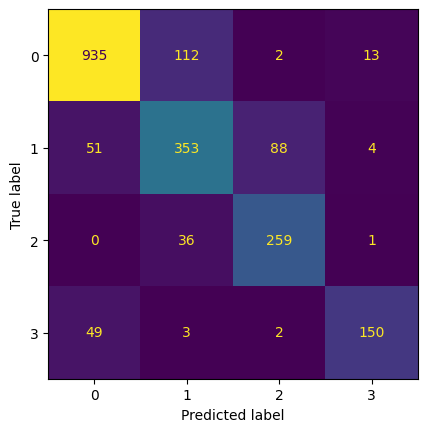

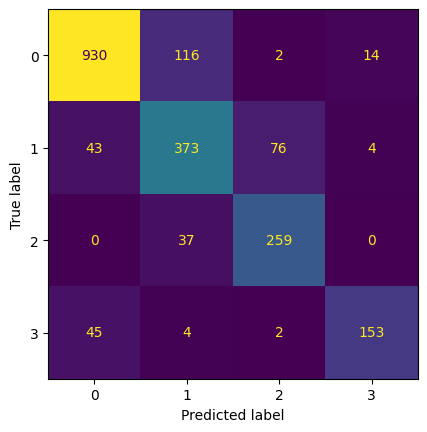

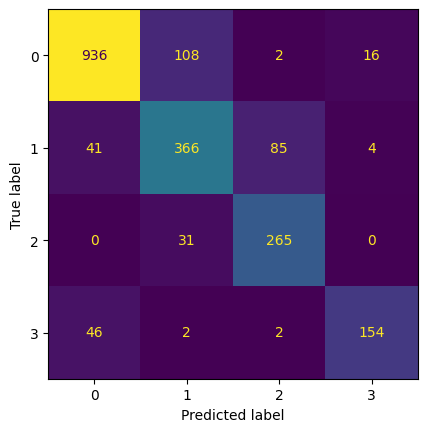

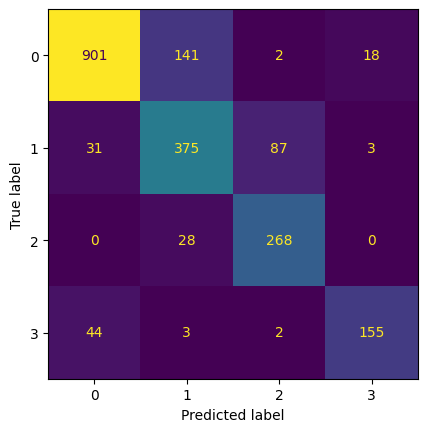

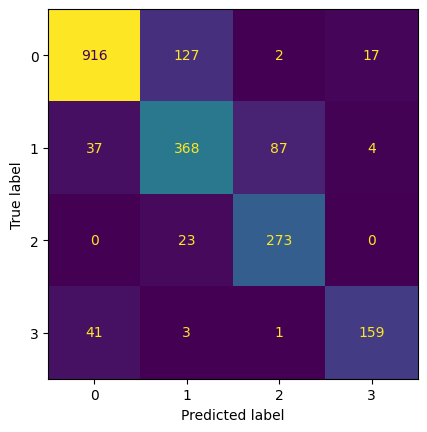

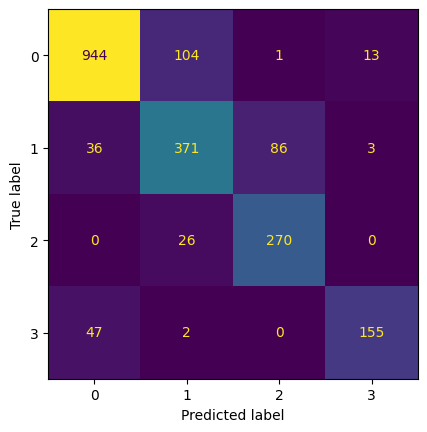

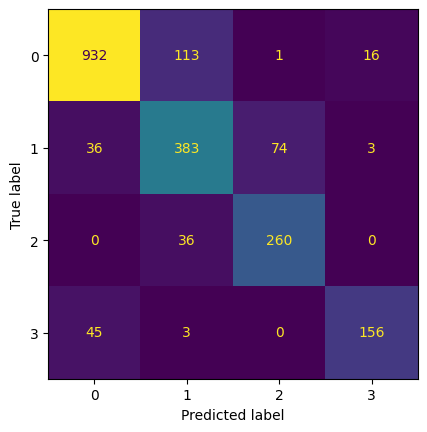

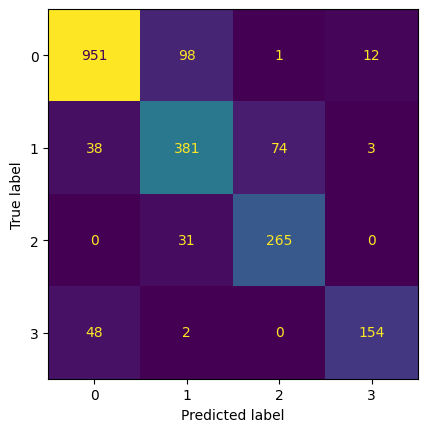

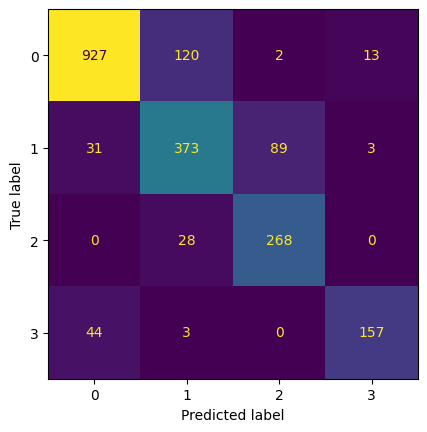

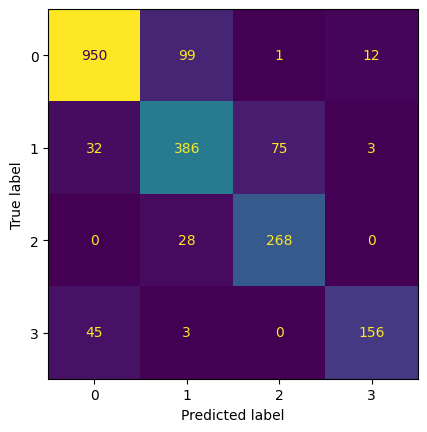

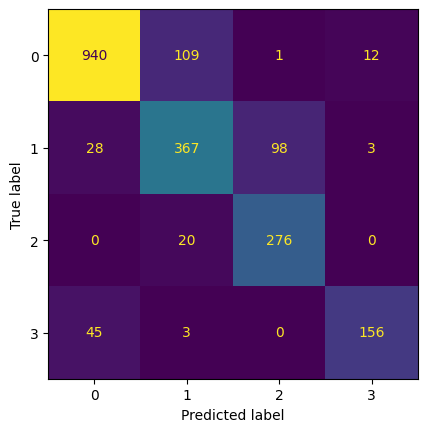

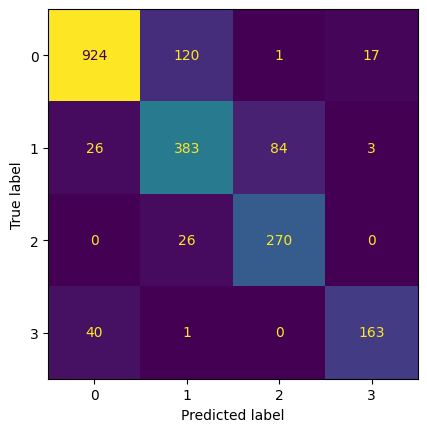

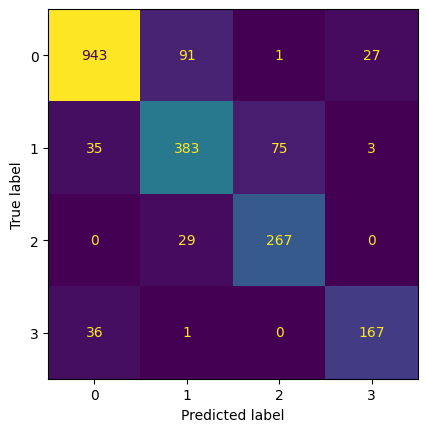

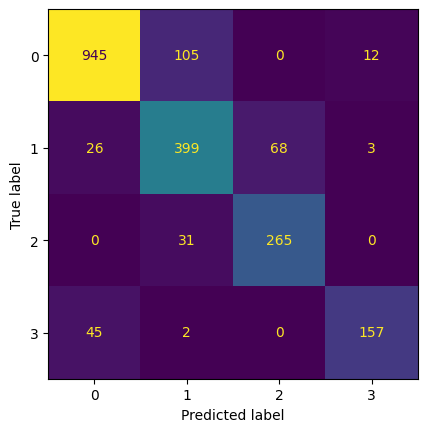

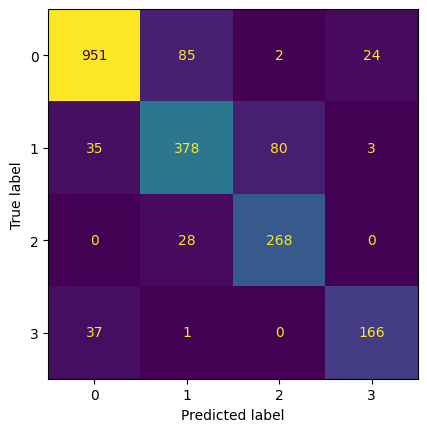

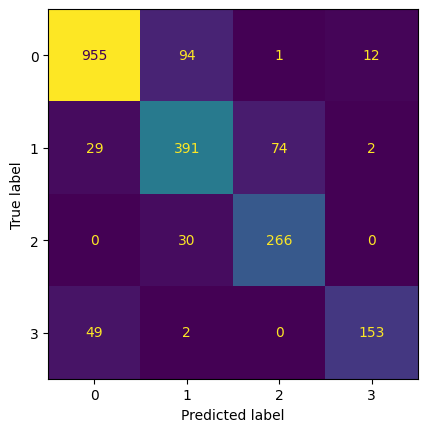

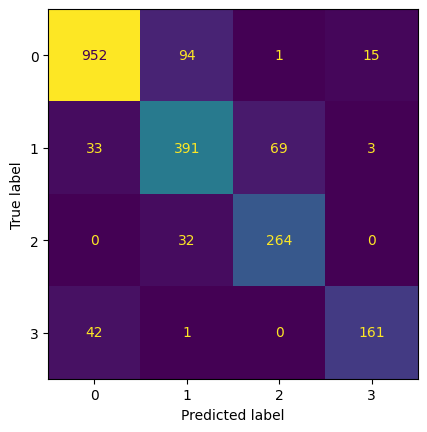

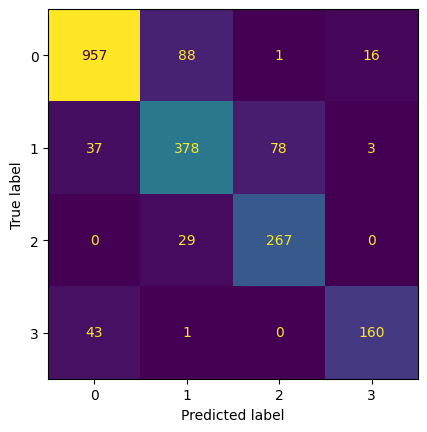

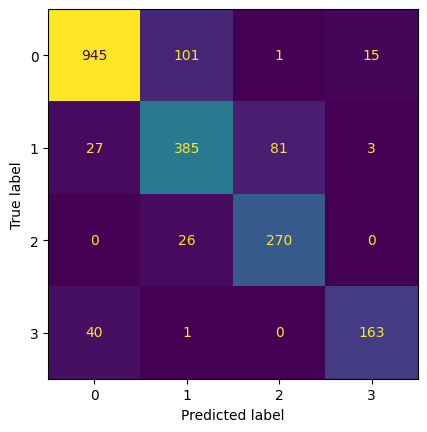

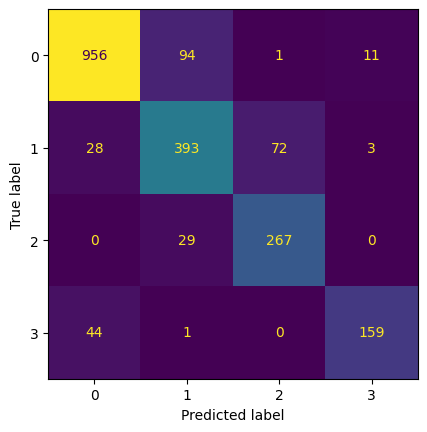

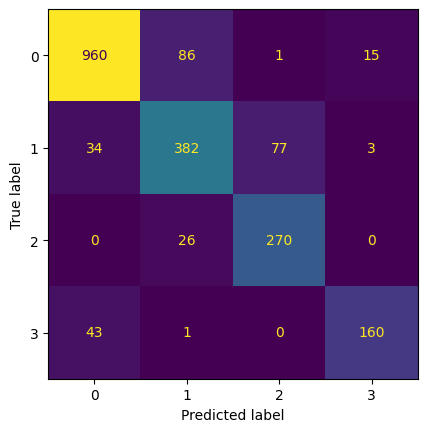

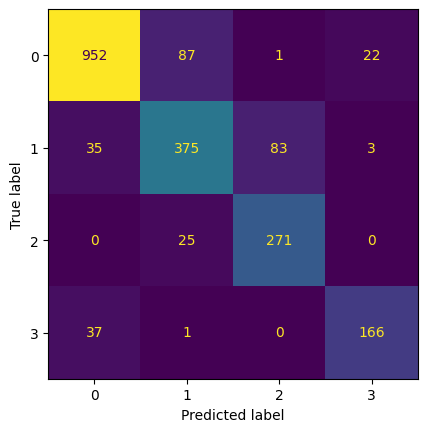

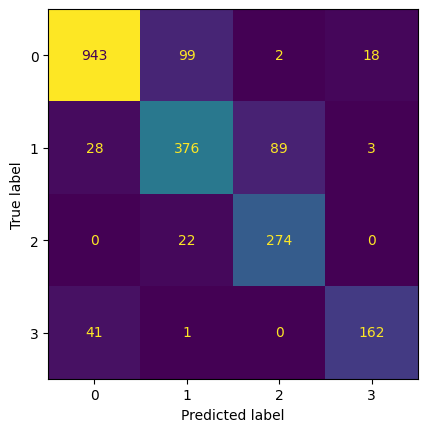

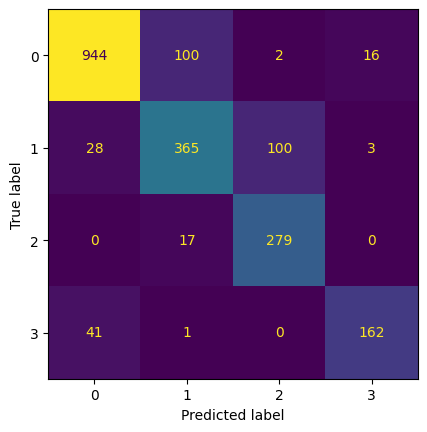

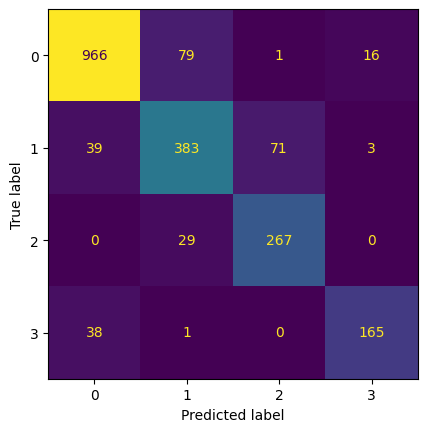

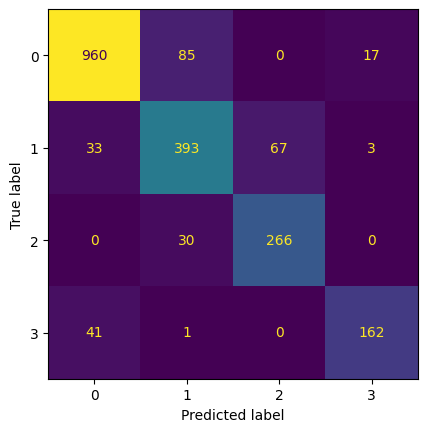

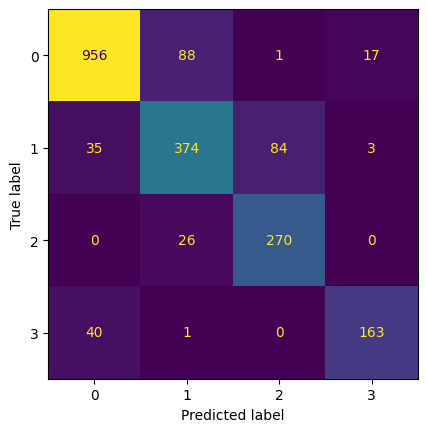

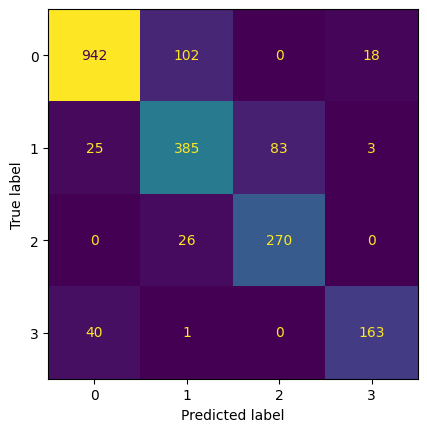

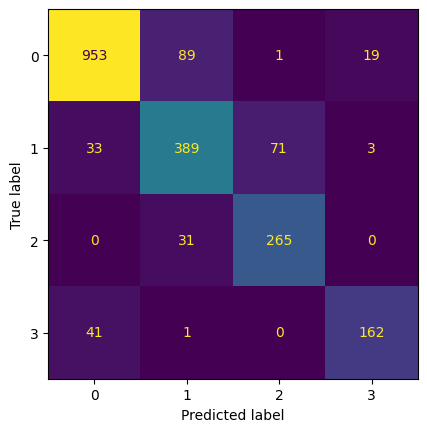

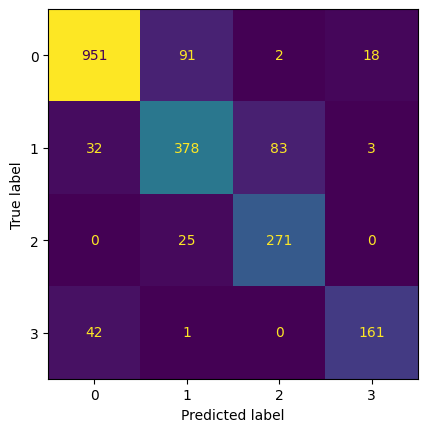

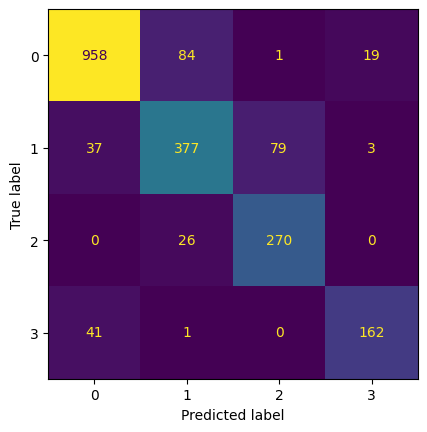

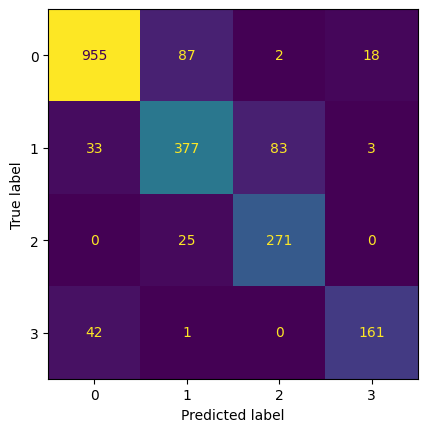

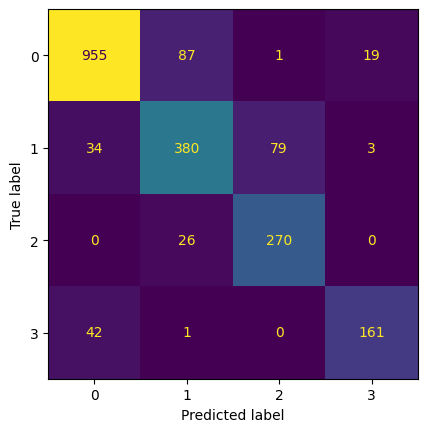

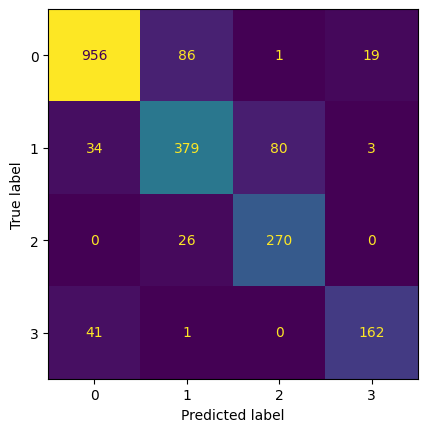

cuda:0


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/327M [00:00<?, ?B/s]

remote: error: cannot lock ref 'refs/heads/main': is at bba2772d1dbb01adcf31aae77bd8c50a11dbfb6d but expected 8d1ee53efdf7fb3a3d77b1b49abd33cfe4c46897        
To https://huggingface.co/gcicceri/organoids-prova_organoid
 ! [remote rejected] main -> main (failed to update ref)
error: failed to push some refs to 'https://huggingface.co/gcicceri/organoids-prova_organoid'



OSError: remote: error: cannot lock ref 'refs/heads/main': is at bba2772d1dbb01adcf31aae77bd8c50a11dbfb6d but expected 8d1ee53efdf7fb3a3d77b1b49abd33cfe4c46897        
To https://huggingface.co/gcicceri/organoids-prova_organoid
 ! [remote rejected] main -> main (failed to update ref)
error: failed to push some refs to 'https://huggingface.co/gcicceri/organoids-prova_organoid'


In [ ]:
# Train the model using the Trainer object
train_results = trainer.train()

# Print the selected device for training
print(device)

# Save the trained model
trainer.save_model()

# Log and save training metrics
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

# Save the training state
trainer.save_state()

# Finish logging with Weights & Biases
wandb.finish()


In [ ]:
# Retrieve the log history from the Trainer state

import matplotlib.pyplot as plt
import math
log_history = trainer.state.log_history

In [ ]:
log_history

[{'loss': 1.3849,
  'learning_rate': 6.944444444444444e-08,
  'epoch': 0.03,
  'step': 1},
 {'loss': 1.4018,
  'learning_rate': 1.3888888888888888e-07,
  'epoch': 0.06,
  'step': 2},
 {'loss': 1.4112,
  'learning_rate': 2.0833333333333333e-07,
  'epoch': 0.08,
  'step': 3},
 {'loss': 1.4054,
  'learning_rate': 2.7777777777777776e-07,
  'epoch': 0.11,
  'step': 4},
 {'loss': 1.4111,
  'learning_rate': 3.472222222222223e-07,
  'epoch': 0.14,
  'step': 5},
 {'loss': 1.3719,
  'learning_rate': 4.1666666666666667e-07,
  'epoch': 0.17,
  'step': 6},
 {'loss': 1.3841,
  'learning_rate': 4.861111111111112e-07,
  'epoch': 0.19,
  'step': 7},
 {'loss': 1.3771,
  'learning_rate': 5.555555555555555e-07,
  'epoch': 0.22,
  'step': 8},
 {'loss': 1.3794, 'learning_rate': 6.25e-07, 'epoch': 0.25, 'step': 9},
 {'loss': 1.3608,
  'learning_rate': 6.944444444444446e-07,
  'epoch': 0.28,
  'step': 10},
 {'loss': 1.377,
  'learning_rate': 7.63888888888889e-07,
  'epoch': 0.3,
  'step': 11},
 {'loss': 1.344

In [ ]:
import csv
# Write log history to a CSV file
with open('list.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for element in log_history:
        writer.writerow([element])

In [ ]:
#read csv
import csv
# Read a CSV file and print its contents
with open('D:\HDD Giovanni\PycharmProjects\organoid\list.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        print(row)

["{'loss': 1.3849, 'learning_rate': 6.944444444444444e-08, 'epoch': 0.03, 'step': 1}"]
["{'loss': 1.4018, 'learning_rate': 1.3888888888888888e-07, 'epoch': 0.06, 'step': 2}"]
["{'loss': 1.4112, 'learning_rate': 2.0833333333333333e-07, 'epoch': 0.08, 'step': 3}"]
["{'loss': 1.4054, 'learning_rate': 2.7777777777777776e-07, 'epoch': 0.11, 'step': 4}"]
["{'loss': 1.4111, 'learning_rate': 3.472222222222223e-07, 'epoch': 0.14, 'step': 5}"]
["{'loss': 1.3719, 'learning_rate': 4.1666666666666667e-07, 'epoch': 0.17, 'step': 6}"]
["{'loss': 1.3841, 'learning_rate': 4.861111111111112e-07, 'epoch': 0.19, 'step': 7}"]
["{'loss': 1.3771, 'learning_rate': 5.555555555555555e-07, 'epoch': 0.22, 'step': 8}"]
["{'loss': 1.3794, 'learning_rate': 6.25e-07, 'epoch': 0.25, 'step': 9}"]
["{'loss': 1.3608, 'learning_rate': 6.944444444444446e-07, 'epoch': 0.28, 'step': 10}"]
["{'loss': 1.377, 'learning_rate': 7.63888888888889e-07, 'epoch': 0.3, 'step': 11}"]
["{'loss': 1.3444, 'learning_rate': 8.333333333333333

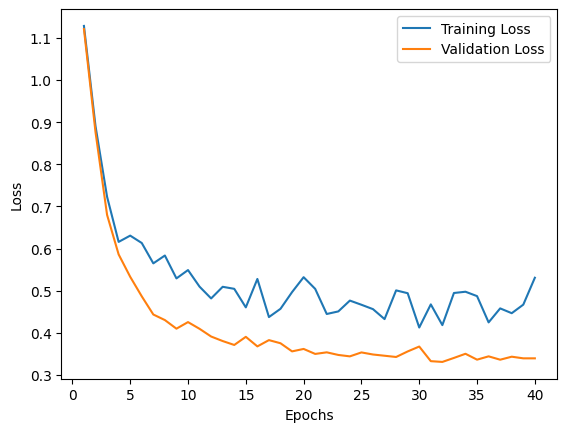

In [ ]:
import csv
import ast
import matplotlib.pyplot as plt

# Read the log history from a CSV file and plot training and validation loss
with open('D:\HDD Giovanni\PycharmProjects\organoid\list.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    loss_values = {}
    eval_loss_values = {}

    # Extract loss and evaluation loss values from the log history
    for row in reader:
        data = ast.literal_eval(row[0])
        if 'loss' in data:
            loss_values[data['step']] = data['loss']
        if 'eval_loss' in data:
            eval_loss_values[data['step']] = data['eval_loss']

    # Find common training and evaluation steps
    common_steps = sorted(set(loss_values.keys()) & set(eval_loss_values.keys()))

    # Retrieve corresponding loss values
    common_loss_values = [loss_values[step] for step in common_steps]
    common_eval_loss_values = [eval_loss_values[step] for step in common_steps]

    # Plot training and validation loss
    plt.plot(range(1,len(common_steps)+1), common_loss_values, label='Training Loss')
    plt.plot(range(1,len(common_steps)+1), common_eval_loss_values, label='Validation Loss')

    # Set plot labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Save the plot as an image
    plt.savefig('D:\HDD Giovanni\PycharmProjects\organoid\Loss_plot_line_drawings.png', format='png', dpi=600, bbox_inches='tight')
    #plt.title('Training and Validation Loss')
    # Show the plot
    plt.show()


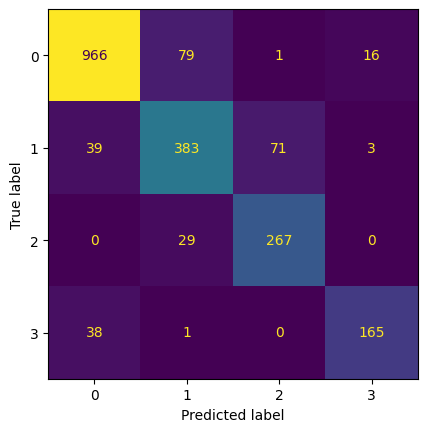

***** eval metrics *****
  epoch                   =      39.72
  eval_accuracy           =     0.8654
  eval_loss               =      0.333
  eval_runtime            = 0:00:08.95
  eval_samples_per_second =    229.838
  eval_steps_per_second   =      1.899
ok


In [ ]:
# Evaluate the model on the validation dataset
val_metrics = trainer.evaluate()
# Log and save evaluation metrics
trainer.log_metrics("eval", val_metrics)
trainer.save_metrics("eval", val_metrics)
# Print a message to indicate successful evaluation
print ('ok')

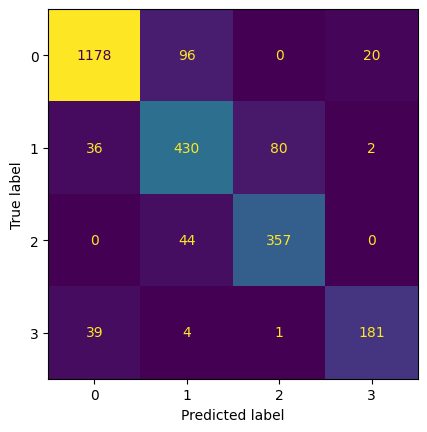

PredictionOutput(predictions=array([[ 4.794035  ,  0.24664447, -3.7044384 , -0.80505925],
       [ 4.3157697 , -0.24565928, -3.5440373 , -0.15239425],
       [ 4.502     , -0.5835366 , -3.3224497 ,  0.09044248],
       ...,
       [ 2.5605624 ,  1.1246136 , -2.0834374 , -1.4481455 ],
       [ 3.2741752 , -0.41620782, -3.424923  ,  0.9383845 ],
       [ 3.4586475 , -2.0708194 , -2.9296954 ,  2.2721283 ]],
      dtype=float32), label_ids=array([0, 0, 0, ..., 3, 3, 3], dtype=int64), metrics={'test_loss': 0.3244295120239258, 'test_accuracy': 0.8695299837925445, 'test_runtime': 13.1505, 'test_samples_per_second': 187.673, 'test_steps_per_second': 1.521})

In [ ]:
# Set the model to evaluation mode
model.eval()
# Use the Trainer object to predict on the test dataset and compute test metrics
test_metrics = trainer.predict(test_ds)
# Return the computed test metrics
test_metrics

In [ ]:
test_ds

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define a function to compute evaluation metrics
def compute_metrics(pred):
    # Extract true labels and predicted labels from the prediction
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute precision, recall, f1-score, and accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    # Return computed metrics
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [ ]:
test_metrics

In [ ]:
# computes evaluation metrics
compute_metrics(test_metrics)

{'accuracy': 0.8695299837925445,
 'f1': 0.8705665914133329,
 'precision': 0.8729849137958556,
 'recall': 0.8695299837925445}

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Define a function to compute evaluation metrics including sensitivity and specificity
def compute_metrics(pred):
    # Extract true labels and predicted labels from the prediction
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute precision, recall, F1-score, and accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(labels, preds)

    # Compute sensitivity and specificity for each class
    sensitivity_list = []
    specificity_list = []
    for i in range(4):  # Assuming there are 4 classes
        tp = conf_matrix[i, i]
        fn = sum(conf_matrix[i, :]) - tp
        fp = sum(conf_matrix[:, i]) - tp
        tn = sum(sum(conf_matrix)) - (tp + fn + fp)

        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)

    # Return computed metrics
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'sensitivity': sensitivity_list,
        'specificity': specificity_list
    }


In [ ]:
#print out a dictionary containing the computed evaluation metrics
compute_metrics(test_metrics)

{'accuracy': 0.8695299837925445,
 'f1': 0.8705665914133329,
 'precision': 0.8729849137958556,
 'recall': 0.8695299837925445,
 'sensitivity': [0.910355486862442,
  0.7846715328467153,
  0.8902743142144638,
  0.8044444444444444],
 'specificity': [0.9361158432708688,
  0.925,
  0.9608127721335269,
  0.990191707534552]}

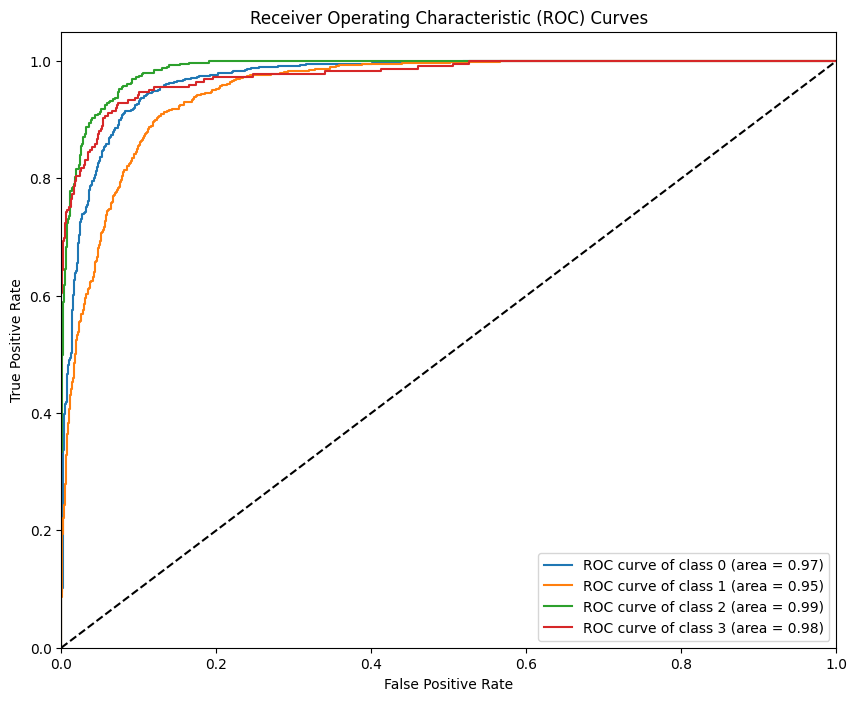

In [ ]:
#plot ROC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(pred):
    labels = pred.label_ids
    probs = pred.predictions  # Assuming this gives probability scores for each class

    # For multi-class ROC plotting
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = probs.shape[1]  # Assuming that probs has shape [n_samples, n_classes]

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels == i, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.savefig('D:\HDD Giovanni\PycharmProjects\organoid\\roc_curves.png', format='png', dpi=600, bbox_inches='tight')
    plt.show()

# Call this function with your predictions to plot the ROC curves
plot_roc_curves(test_metrics)


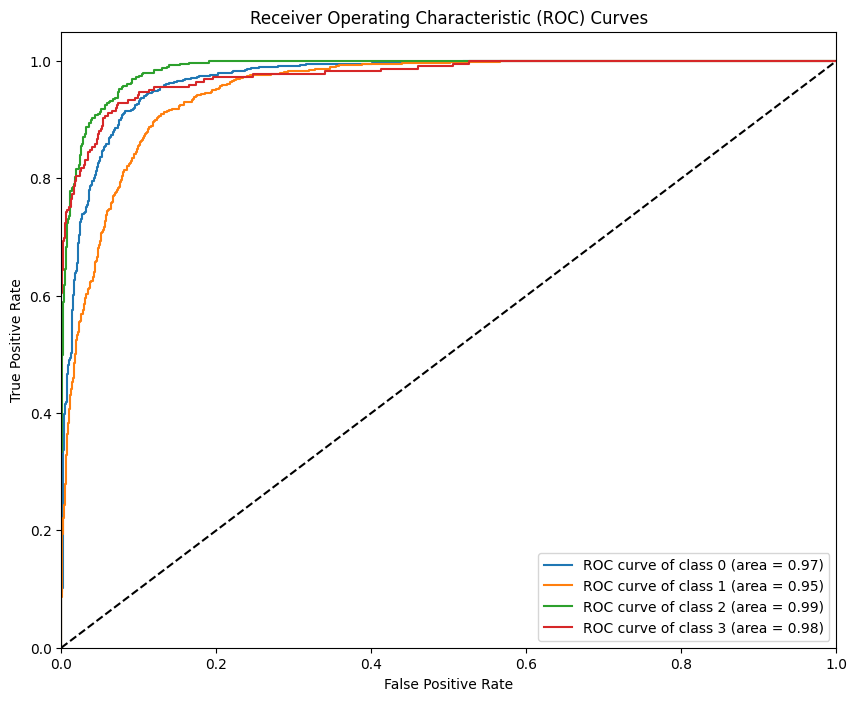

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(pred):
    labels = pred.label_ids
    probs = pred.predictions  # Assuming this gives probability scores for each class

    # For multi-class ROC plotting
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = probs.shape[1]  # Assuming that probs has shape [n_samples, n_classes]

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels == i, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Save fpr and tpr to a CSV
    with open('D:\HDD Giovanni\PycharmProjects\organoid\\roc_data.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Class", "FPR", "TPR"])
        for i in range(n_classes):
            for f, t in zip(fpr[i], tpr[i]):
                writer.writerow([i, f, t])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.savefig('D:\HDD Giovanni\PycharmProjects\organoid\\roc_curves.png', format='png', dpi=600, bbox_inches='tight')
    plt.show()

#  call plot_roc_curves(pred) to get the plots and also save the fpr, tpr data to a CSV file.
plot_roc_curves(test_metrics)

In [ ]:
import numpy as np

# Extract predictions and true labels
predictions = np.argmax(test_metrics.predictions, axis=1) if test_metrics.predictions.ndim == 2 else test_metrics.predictions
true_labels = test_metrics.label_ids



In [ ]:
true_labels

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [ ]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
#instal openpyxl library for working with Excel files
!pip install openpyxl

  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/6a/94/a59521de836ef0da54aaf50da6c4da8fb4072fb3053fa71f052fd9399e7a/openpyxl-3.1.2-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
   ------------------------------- -------- 194.6/250.0 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 250.0/250.0 kB 3.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Create a DataFrame with the true labels and predictions
df = pd.DataFrame({
    'Index': np.arange(len(true_labels)),
    'True Labels': true_labels,
    'Predictions': predictions
})

# Save the DataFrame to an Excel file
df.to_excel('predictions.xlsx', index=False)

In [ ]:
# Compare predictions with true labels
mismatches = predictions != true_labels

# Extract indices of mismatches
mismatched_indices = np.where(mismatches)[0]


In [ ]:
#print the indices of the model predictions that do not match the true labels.
mismatched_indices

array([   4,   11,   13,  101,  104,  166,  169,  200,  206,  212,  267,
        280,  287,  327,  333,  375,  383,  391,  402,  404,  405,  406,
        451,  459,  467,  471,  501,  505,  517,  534,  538,  581,  586,
        587,  592,  602,  615,  625,  631,  633,  645,  646,  675,  691,
        697,  698,  699,  702,  703,  705,  707,  726,  745,  746,  755,
        760,  762,  773,  778,  780,  788,  789,  797,  808,  810,  812,
        813,  819,  828,  829,  830,  839,  842,  856,  857,  858,  863,
        864,  867,  869,  875,  878,  889,  891,  912,  939,  992,  997,
       1002, 1003, 1006, 1014, 1018, 1031, 1032, 1034, 1038, 1039, 1040,
       1065, 1077, 1078, 1079, 1082, 1099, 1121, 1146, 1174, 1188, 1200,
       1205, 1211, 1213, 1215, 1217, 1284, 1294, 1300, 1301, 1303, 1306,
       1309, 1313, 1316, 1326, 1327, 1329, 1330, 1337, 1339, 1340, 1343,
       1349, 1350, 1358, 1368, 1369, 1370, 1372, 1373, 1375, 1379, 1383,
       1386, 1391, 1395, 1397, 1399, 1401, 1428, 14